In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk
import colorama as col

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
#Dataset.process_for_embedding()
#sentences = Dataset.get_sentences()
#fn.write_sentences('sentences')
sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')
model = Word2Vec.load('W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# FFNN Testing

In [5]:
train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing()
validation_cases.process_for_testing()
test_cases.process_for_testing()

In [7]:
sets = {}
sets['train_set'], sets['train_labels'], _ = train_cases.get_ff_sets(model)
sets['validation_set'], sets['validation_labels'], _ = validation_cases.get_ff_sets(model)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_cases.get_ff_sets(model)

In [8]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set_training(sets['train_set'], sets['train_labels'], 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.05% non-med: 0.95%
Ratio: med: 0.13% non-med: 0.87%


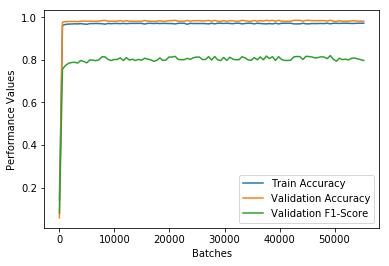

FInal Values: TrAcc: 0.971, ValAcc: 0.981, ValF1: 0.797
Test F1-Score: 0.821



In [9]:
NN = FF_Model(layers=[50])
NN.build_graph()
_,_,_,_ = NN.train(sets, epochs=10, batch=50, show_plot=True, show_progress=True)

In [10]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [11]:
TP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 0)])
TN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 1)])
FP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 1)])
FN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
452	10512	133	64


In [12]:
print(', '.join([sets['test_words'][a] for a in range(len(sets['test_words'])) if res[a] == 0 and tru[a] == 1]))

codeine, (, tablets, sodium, potassium, chloride, magnesium, boluses, sodium, potassium, chloride, magnesium, inhibitor, agents, tylenol, insulin, (, (, hep, (, micro, (, (, (, (, (, (, sedation, (, antibiotics, (, m/w/f, grana, aspirin, insulin, prandial, (, m/w/f, caffeine, (, (, (, (, (, (, (, morphine, sodium, potassium, chloride, calcium, magnesium, (, loading, iron, monday-wednesday-friday, flagyl, monday-wednesday-friday, monday-wednesday-friday, medication, monday-wednesday-friday, monday-wednesday-friday, topical, medication, penicillin, jb<num>, (, topical, (, (, hcl, (, topical, (, (, (, (, (, (, (, (, (, (, (, hydrate, riss, (, (, (, (, quinine, aspirin, (, (, (, (, (, (, (, (, (, (, (, (, (, <num>.<num>-<num>, (, (, (, aspirin, motrin, (, (, (, (, (, spray, (, sodium, aspirin, (, (, (, (, <num>meq, aspirin, (, (, (, (, ppi, iss, (


In [13]:
out = []
for a in range(len(sets['test_words'])):
    if res[a] == 0 and tru[a] == 0:
        out.append(col.Back.GREEN + sets['test_words'][a].upper() + col.Back.RESET)
    elif res[a] == 0 and tru[a] == 1:
        out.append(col.Back.YELLOW + sets['test_words'][a].upper() + col.Back.RESET)
    elif res[a] == 1 and tru[a] == 0:
        out.append(col.Back.RED + sets['test_words'][a].upper() + col.Back.RESET)
    else:
        out.append(sets['test_words'][a])
        
print(' '.join(out))

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [14]:
proba = []
for i in range(len(res)):
    if not (sets['test_words'][i] == ')' or sets['test_words'][i] == '('):
        proba.append([sets['test_words'][i], res[i], tru[i]])

In [15]:
TP = len([a for a in range(len(proba)) if (proba[a][1] == 0) and (proba[a][2] == 0)])
TN = len([a for a in range(len(proba)) if (proba[a][1] == 1) and (proba[a][2] == 1)])
FP = len([a for a in range(len(proba)) if (proba[a][1] == 0) and (proba[a][2] == 1)])
FN = len([a for a in range(len(proba)) if (proba[a][1] == 1) and (proba[a][2] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
427	10434	62	39


In [16]:
sk.metrics.f1_score(np.array(proba)[:,2].astype(int), np.array(proba)[:,1].astype(int), pos_label=0, average='binary')

0.89424083769633511

In [17]:
print(', '.join([(proba[a][0]) for a in range(len(proba)) if proba[a][1] == 0 and proba[a][2] == 1]))

codeine, tablets, sodium, potassium, chloride, magnesium, boluses, sodium, potassium, chloride, magnesium, inhibitor, agents, tylenol, insulin, hep, micro, sedation, antibiotics, m/w/f, grana, aspirin, insulin, prandial, m/w/f, caffeine, morphine, sodium, potassium, chloride, calcium, magnesium, loading, iron, monday-wednesday-friday, flagyl, monday-wednesday-friday, monday-wednesday-friday, medication, monday-wednesday-friday, monday-wednesday-friday, topical, medication, penicillin, jb<num>, topical, hcl, topical, hydrate, riss, quinine, aspirin, <num>.<num>-<num>, aspirin, motrin, spray, sodium, aspirin, <num>meq, aspirin, ppi, iss


In [18]:
out = []
for a in range(len(proba)):
    if proba[a][1] == 0 and proba[a][2] == 0:
        out.append(col.Back.GREEN + proba[a][0].upper() + col.Back.RESET)
    elif proba[a][1] == 0 and proba[a][2] == 1:
        out.append(col.Back.YELLOW + proba[a][0].upper() + col.Back.RESET)
    elif proba[a][1] == 1 and proba[a][2] == 0:
        out.append(col.Back.RED + proba[a][0].upper() + col.Back.RESET)
    else:
        out.append(sets['test_words'][a])
        
print(' '.join(out))

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [21]:
TP, FP, FN = 0, 0, 0
testers = Dataset.get_DS(stage='train', labelled='yes')

for i in range(testers.size):
    current_ds = pool(data=[testers.data[i]])
    #current_ds.show_info()
    current_ds.process_for_testing()
    cur_set, cur_lab, cur_words = current_ds.get_ff_sets(model=model, left_words=0, right_words=0)
    
    cur_res = NN.predict(cur_set)
    cur_tru = np.argmax(cur_lab, 1)
    
    for j in range(len(cur_res)):
        if (cur_words[j] == ')' or cur_words[j] == '('):
            cur_res[j] = 1
            cur_tru[j] = 1
            
    res_words = set()
    tru_words = set()
    res_inside = False
    tru_inside = False
    res_med = ''
    tru_med = ''
    for k in range(len(cur_words)):
        if not res_inside:
            if cur_res[k] == 0:
                res_med = cur_words[k]
                res_inside = True
        else:
            if cur_res[k] == 0:
                res_med = res_med + ' ' + cur_words[k]
            else:
                res_words.add(res_med)
                res_med = 0
                res_inside = False

        if not tru_inside:
            if cur_tru[k] == 0:
                tru_med = cur_words[k]
                tru_inside = True
        else:
            if cur_tru[k] == 0:
                tru_med = tru_med + ' ' + cur_words[k]
            else:
                tru_words.add(tru_med)
                tru_med = 0
                tru_inside = False
    
    #print(', '.join([col.Back.YELLOW + word + col.Back.RESET if word not in tru_words else word for word in res_words]))
    #print(', '.join([col.Back.RED + word + col.Back.RESET if word not in res_words else word for word in tru_words]))
    
    TP += len([1 for med in res_words if med in tru_words])
    FP += len([1 for med in res_words if med not in tru_words])
    FN += len([1 for med in tru_words if med not in res_words])

print('TP\tFP\tFN\n{}\t{}\t{}'.format(TP, FP, FN))
print('F1-score: {:.4f}'.format((2 * TP) / ( 2 * TP + FP + FN)))

TP	FP	FN
205	62	29
F1-score: 0.8184


In [25]:
TP, FP, FN = 0, 0, 0
testers = Dataset.get_DS(stage='train', labelled='yes')

for i in range(testers.size):
    current_ds = pool(data=[testers.data[i]])
    #current_ds.show_info()
    current_ds.process_for_testing()
    cur_set, cur_lab, cur_words = current_ds.get_ff_sets(model=model, left_words=0, right_words=0)
    
    cur_res = NN.predict(cur_set)
    cur_tru = np.argmax(cur_lab, 1)
    
    for j in range(len(cur_res)):
        if (cur_words[j] == ')' or cur_words[j] == '('):
            cur_res[j] = 1
            cur_tru[j] = 1
            
    res_words = set()
    res_inside = False
    res_med = ''
    for k in range(len(cur_words)):
        if not res_inside:
            if cur_res[k] == 0:
                res_med = cur_words[k]
                res_inside = True
        else:
            if cur_res[k] == 0:
                res_med = res_med + ' ' + cur_words[k]
            else:
                res_words.add(res_med)
                res_med = 0
                res_inside = False
    
    tru_words = set()
    for term in re.finditer(r'm="[^"]+"', current_ds.data[0].raw_labels):
        term = term.group()[3:-1]
        term = re.sub(r'\d+', '<num>', term)
        term = re.sub(r'([A-Za-z]);', r'\1', term)
        term = re.sub(r'([A-Za-z])\.', r'\1', term)
        tru_words.add(term)
    
    #print(', '.join([col.Back.YELLOW + word + col.Back.RESET if word not in tru_words else word for word in res_words]) + '\n')
    #print(', '.join([col.Back.RED + word + col.Back.RESET if word not in res_words else word for word in tru_words]) + '\n')
    
    TP += len([1 for med in res_words if med in tru_words])
    FP += len([1 for med in res_words if med not in tru_words])
    FN += len([1 for med in tru_words if med not in res_words])

print('TP\tFP\tFN\n{}\t{}\t{}'.format(TP, FP, FN))
print('F1-score: {:.4f}'.format((2 * TP) / ( 2 * TP + FP + FN)))

TP	FP	FN
173	94	45
F1-score: 0.7134


# HyperParameter Scan

In [ ]:
emb_num = 1
NN_num = 1
emb_sizes = [30, 50, 100]
target_saturations = [0.05, 0.1, 0.3]
layers = [[30], [50], [100]]
dropouts = [0.3, 0.5, 0.8, 1.0]
learn_rates = [0.001, 0.01, 0.1]
epoch_nums = [10, 50, 100]
batch_sizes = [10, 50, 100]


model_num = emb_num * NN_num * len(emb_sizes) * len(layers) * len(dropouts) * \
            len(learn_rates) * len(epoch_nums) * len(batch_sizes) * len(target_saturations)
target = target_dict['medications']
report_percentage = 10

print(model_num)

In [ ]:
labelled_cases = Dataset.get_DS(labelled='yes')
labelled_cases.process_for_testing()

In [ ]:
iterations = [emb_sizes, target_saturations, layers, dropouts, learn_rates, epoch_nums, batch_sizes]

In [ ]:
n = 0
parameters = []
results = []
timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])

f = open('tests/Model2/' + timestamp, 'w+')
print('EmbSz:\tSat:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:')
f.write('EmbSz:\tSat:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:\n')
for par in itertools.product(*iterations):
    best = 0
    parameters.append(par)
    for i in range(emb_num):
        model = Word2Vec(sentences, min_count=1, size=par[0])
        sets = fn.get_ff_traintest(labelled_cases, model)
        fn.saturate_training_set_labels(sets, model, target, par[1])
        for j in range(NN_num):
            n += 1
            print('Model Number: {}/{}'.format(n, model_num), end='\r')
            NN = FF_Model(input_size=par[0], layers=par[2], dropout=par[3], learn_rate=par[4])
            NN.build_graph()
            _, _, _, score = NN.train(sets, epochs=par[5], batch=par[6], report_percentage=report_percentage)
            best = max(best, score)
    results.append(best)
    print('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}'.format(*parameters[-1], results[-1]))
    f.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}\n'.format(*parameters[-1], results[-1]))
    
print('Max Performance: {:.4f}'.format(max(results)))  
f.write('Max Performance: {:.4f}\n'.format(max(results)))
f.close()